In [1]:
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
import bioread
from scipy.fftpack import fft
from scipy import signal
from scipy.signal import find_peaks

In [8]:
def FIRrespt(ninput,xinput,nh,h):
    Nx=len(xinput);Nh=len(h);conv=np.convolve(xinput,h);n0=ninput[0]+nh[0];Nconv=Nx+Nh-1;nconv=np.arange(n0,n0 + Nconv)
    R = np.vstack((nconv,conv)).T
    return R   

def FIRrespf(w,h):
    Nh=len(h); H = 0
    for i in np.arange(Nh):
        H = H + h[i]*np.exp(-1j*w*i)
    R = np.vstack((w,abs(H),np.angle(H))).T
    return R 

def IIRrespt(xinput,c,d):
    N1 = len(xinput) # 
    nx = np.arange(-(len(c)-1),N1)
    x = xinput
    for k in np.arange(len(c)-1):
        x = np.insert(x,0,0)
    ny = np.arange(-(len(d)-1),N1)
    y = np.arange(0,len(ny),dtype=np.float64)
    for k in np.arange(len(d)-1):
        y[k] = 0
    for i in np.arange(len(d)-1,len(y)):
        z = 0
        for j in np.arange(1,len(d)):
            z = z - d[j]*y[i-j] + c[j]*x[i-j]
        y[i] = (z + c[0]* x[i])/d[0]
    R = np.vstack((ny,y)).T
    return R

def IIRrespf(w,c,d):
    Nc=len(c); Nd=len(d); Hnum = 0; Hden = 0
    for i in np.arange(Nc):
        Hnum = Hnum + c[i]*np.exp(-1j*w*i)
    for i in np.arange(Nd):
        Hden = Hden + d[i]*np.exp(-1j*w*i)
    H = np.divide(Hnum,Hden)
    R = np.vstack((w,abs(H),np.angle(H))).T
    return R

def vent(vent_name,M):
    nw = np.arange(2*M+1)
    if vent_name == 'rectangular':
        ventana = np.piecewise(nw,nw>=0,[1,0])
    elif vent_name == 'hanning':
        ventana = 0.5*(1+np.cos(2*np.pi*(nw-M)/(2*M+1)))
    elif vent_name == 'hamming':
        ventana = 0.54+0.46*np.cos(2*np.pi*(nw-M)/(2*M+1))
    elif vent_name == 'blackman':
        ventana = 0.42+0.5*np.cos(2*np.pi*(nw-M)/(2*M+1))+0.08*np.cos(4*np.pi*(nw-M)/(2*M+1))
    return np.vstack((nw,ventana)).T

def Hvent(w,ventana):
    z = 0
    for k in np.arange(len(ventana)):
        z = z + ventana[k]*np.exp(-1j*w*k)
    aux = z
    return np.vstack((w,abs(aux),np.angle(aux))).T

In [9]:
def IIR(nombreArchivo):
#..................................Ingreso Señal..........................................
    
    ECG = bioread.read_file (nombreArchivo)
    canales = ECG.channels
    for i in np.arange (0,len(canales)):
        print (f"Canal {i}: {canales[i]}")
    t = ECG.time_index.T ;     señal = ECG.channels[0].data

    N = len(señal)
    Fs = ECG.channels[0].samples_per_second
    
#..................................Elimino tendencia ......................................
    A3 = np.arange(0,N,250) #arreglo
    B3 = tuple(A3) #tupla
    señal = signal.detrend(señal,bp=A3)
    señal = señal.astype(float)
#------------------------------------------------------------------------------------------------
    
#.................................Obtengo espectro de señal....................................

    espectro = fft(señal)/N
    w = np.linspace(0,2*np.pi,N)
    eje_f = w*Fs/(2*np.pi)
    
#...........................Analizo el espectro entre los 40 y 65 Hz...........................
    f_min = np.where(eje_f>40)
    f_max = np.where((eje_f>40)&(eje_f<65))
    
    f_m = f_min[0][0] #frecuencia mínima de analisis
    f_M = f_max[0][len(f_max[0])-1] #frecuencia máxima de análisis
    
#..................Determino cual es el valor de mi frecuencia de ruido.........................    
    vm = np.where(abs(espectro)[f_m:f_M]==np.max(abs(espectro)[f_m:f_M]))
    f_r = eje_f[f_m+vm[0][0]] #frecuencia de ruido
    
    
#..................Determino los valores de frecuencias de paso y de rechazo...................
    
    fp1 = (f_r - 2);    fp2 = (f_r + 2)
    fr1 = (f_r - 1);    fr2 = (f_r + 1) 
    
#....................Valores de atenuacion de banda de paso y banda de rechazo 
    gp,gstop = 1, 23.5
#..............................................................................

    wp = np.array([fp1,fp2])/(Fs/2)
    ws = np.array([fr1,fr2])/(Fs/2)
    
    system = signal.iirdesign(wp,ws,gp,gstop,analog=False,ftype='butter')
    wz,Hz = signal.freqz(*system,5000)

    
    
#..................................Filtrado de la señal ................................
    b,a = signal.iirdesign(wp,ws,gp,gstop,analog=False,ftype='butter')
    señal_filtrada = IIRrespt(señal,b,a)
#---------------------------------------------------------------------------------------
 
#..................................Analisis de atenuacion................................

    peaks_max_signal = find_peaks(señal,distance=500)[0]
    peaks_min_signal = find_peaks(-señal,distance=500)[0]
    A_max_signal = señal[peaks_max_signal]
    A_min_signal = señal[peaks_min_signal]

    peaks_max = find_peaks (señal_filtrada[:,1],distance=500)[0]
    peaks_min = find_peaks (-señal_filtrada[:,1],distance=500)[0]
    A_max = señal_filtrada[:,1][peaks_max]
    A_min = señal_filtrada[:,1][peaks_min]
    
    A_signal = A_max_signal - A_min_signal
    A_signal_filtr = A_max - A_min
    
    
    Atenuac = np.arange(len(peaks_max_signal))
    for i in range(len(peaks_max_signal)):
        Atenuac[i] = np.round((A_signal[i]-A_signal_filtr[i])*100/A_signal[i],1)

    Atenuacion = np.mean(Atenuac)

#.......... SNR...............

    max_noise = max(señal_filtrada[:,1][800:1000]) #ruido uniforme en toda la señal
    min_noise = min(señal_filtrada[:,1][800:1000])

    A_noise = max_noise - min_noise
    SNR = np.mean(A_signal_filtr) / A_noise
    SNR_dB = 20*np.log10(SNR)
    

      
    condicion = 1        
    
    while (condicion==1):
              
#.........................amplío la ventana de filtrado................................
        fp1 = fp1-1;        fp2 = fp2+1 

        wp = np.array([fp1,fp2])/(Fs/2)
        ws = np.array([fr1,fr2])/(Fs/2)
    
        system = signal.iirdesign(wp,ws,gp,gstop,analog=False,ftype='butter')
        wz,Hz = signal.freqz(*system,5000)
        
#.......................................Filtro..........................................
        b,a = signal.iirdesign(wp,ws,gp,gstop,analog=False,ftype='butter')
        señal_filtrada_c = IIRrespt(señal,b,a)
#---------------------------------------------------------------------------------------

#..............................Analisis de atenuacion...................................
    
        peaks_max = find_peaks(señal_filtrada_c[:,1],distance=500)[0]
        peaks_min = find_peaks(-señal_filtrada_c[:,1],distance=500)[0]
        
        A_max = señal_filtrada_c[:,1][peaks_max]
        A_min = señal_filtrada_c[:,1][peaks_min]
        
        A_signal_filtr = A_max - A_min

        Atenuac = np.arange(len(peaks_max_signal))
        for i in range(len(peaks_max_signal)):
            Atenuac[i] = np.round((A_signal[i]-A_signal_filtr[i])*100/A_signal[i],1)

        Atenuacion_c = np.mean(Atenuac)

#......................................SNR....................................................
        max_noise = max(señal_filtrada_c[:,1][400:600]) #ruido uniforme en toda la señal
        min_noise = min(señal_filtrada_c[:,1][400:600])

        A_noise = max_noise - min_noise
        SNR_c = np.mean(A_signal_filtr) / A_noise
        SNR_dB_c = 20*np.log10(SNR_c)
       
        
        if SNR_c<SNR:
            condicion = 0
            #.....................Gráfico de señal..........................
            plt.figure(figsize=(20,4),dpi = 600)
            plt.plot(t,señal,label='ECG Original',color='black')
            plt.plot(señal_filtrada[:,0]/Fs,señal_filtrada[:,1],label='ECG-Filtro IIR',color='y')
            plt.legend(fontsize=12)
            plt.title(('Filtro IIR'));plt.xlabel('t seg')
            plt.grid (True)
            
            plt.show()
            print("ATENUACION:",Atenuacion)
            print('SNR:',SNR)
            print('SNR(dB):',SNR_dB)
            
        else:
            #.......................Gráfico de señal...................................
            señal_filtrada = señal_filtrada_c
            SNR = SNR_c; SNR_dB = SNR_dB_c
            Atenuacion = Atenuacion_c
            condicion = 1      
    print('Filtrado finalizado')
        
        

Canal 0: Channel ECG (.05 - 150 Hz): 20167 samples, 1000.0 samples/sec, loaded: True


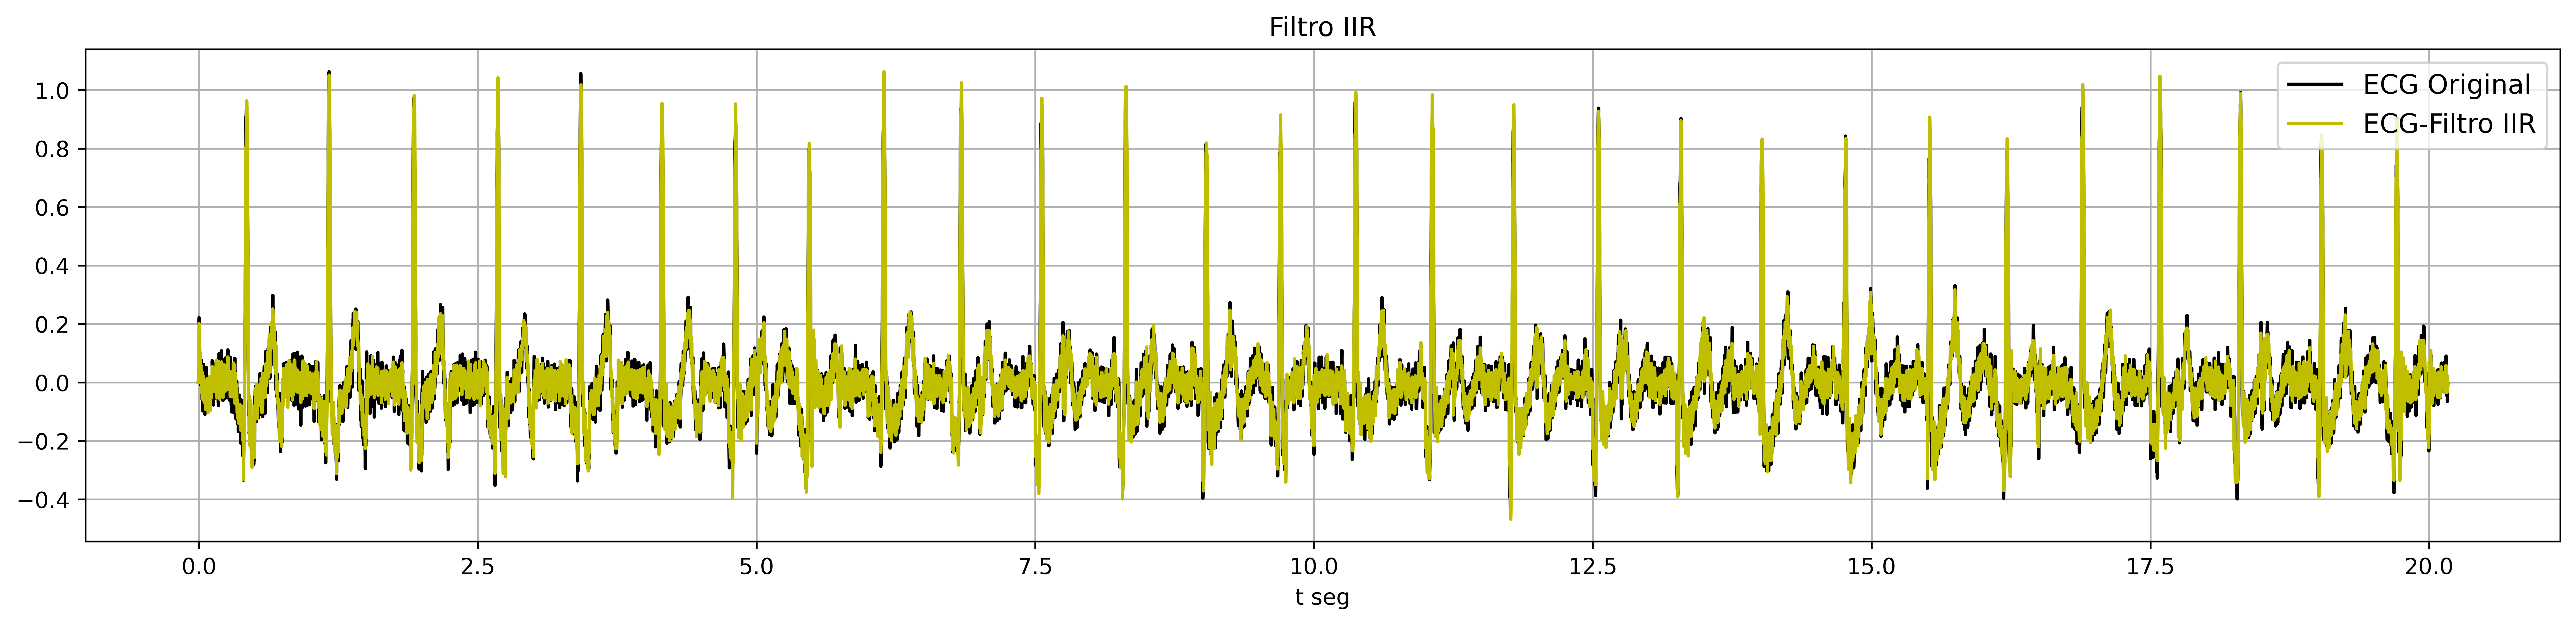

ATENUACION: -1.0
SNR: 7.913464474622451
SNR(dB): 17.96733314102696
Filtrado finalizado


In [10]:
IIR('/Users/paulaaguirrecarol/Desktop/Copia de 2. ecg_sinf.acq')